# Collect User Statistics on *Talk* Pages

## Background

Talk (German: Diskussion) pages are used to suggest changes to the associated main article. They are actively used primarily by readers who want to add or correct content, but are either reluctant to make the changes directly or are unsure how generalizable their request is. Political pages tend to have more talk threads than purely scientific, informative pages. A talk page is divided into sections, each of which forms a discussion thread - there is no official format for discussion threads. Users with administrative rights decide when to archive a page and create a new discussion page. When a user wants to start a new discussion, they edit the discussion page and add a new section with a title and explanation. Random readers, but especially users who are subscribed to the page in question, respond to the new topic. Subscribed users largely form the pool of main editors of the article in question. Thus, they set the direction, tone, and style of an article. Many do clean-up work that gives them enough standing to gain more rights, such as the role of administrator.

Given the political dimension of the worldwide use of glyphosate-containing herbicides, currently controlled by Bayer CropScience, the number of existing talk pages is astonishing when comparing the German and English versions of Glyphosate.

Wikimedia provides an API that allows aggregate statistics to be collected on users unless they have explicitly opted out. However, these tools do not cover talk pages. The purpose of this notebook is to explore that part.


## Content

Here we are looking into a specific page, namely Glyphosate on the German wikipedia and collect the following statistics as listed below.

- **Total number of comments**. Comments given by users in total irrespective of the number of threads. Users can be counted multiple times.
- **First Commentator Rate**. Count how often a user starts a thread, i.e., they are the first commentator. The count is divided by the total number of threads that are considered.
- **Second Commentator Rate**. Count how often a user is the first one who reacts to a newly opened thread. The count is divided by the total number of threads that are considered.
- **Reaction Rate**. Aggregate counts for users who react to a thread, i.e., they might be the second or fourth commentator. They are counted only once per thread. The count is divided by the total number of threads that are considered.


## Usage

This notebook is a [Jupyter](https://jupyter.org) notebook hosted by Google (see [Colab](https://research.google.com/colaboratory/faq.html)) and can be run instantly on your account. Alternatively, you can run this notebook on your personal Jupyter installation.
There are two types of cells: text (like this) and code cells (subsequent cell). To retrieve the final figures you need to execute all code cells. 
To run a cell you mark a cell and click the run icon occurring on the top left corner (or press CMD + Return). To run the analysis on a different wikipedia page, replace the PAGE_URL in the code cell below.

You can try other topics by replacing the url stored in the PAGE_URL variable (line 4 below). As this parser could not be tested against all existing topics, you may encounter script errors if the html format differs. In such a case, do not hesitate to report errors on GitHub.

Marvin Oppong

In [1]:
### any changes in this cell require a re-run of the subsequent cell
## paste here any url of the page you are interest in
#PAGE_URL = 'https://en.wikipedia.org/wiki/Glyphosate'
PAGE_URL = 'https://de.wikipedia.org/wiki/Glyphosat'

## display only the top k editors w.r.t. total number of edits in a figure
TOPK = 25

# look only at edits after indicated stard date (format dd-mm-yyyy)
START_DATE_STR = '01-01-2015'

In [2]:
from collections import Counter
import matplotlib.pylab as plt
from pandas import DataFrame
from prompt_toolkit.completion.fuzzy_completer import namedtuple
import re
import requests
import seaborn as snb
import sys
import time
from typing import List, Union
from urllib.request import urlopen

In [3]:
## Definitions
START_DATE = time.strptime(START_DATE_STR, '%d-%m-%Y')

print('INFO:\tedits before {}-{}-{} will be ignored'.format(START_DATE.tm_mday, START_DATE.tm_mday, START_DATE.tm_year))

PAGE_RX = re.compile(r'^https\:\/\/(\w{2})\.wikipedia\.org.+?\/(.+)$')
LANG = None
TOPIC = None
try:
  LANG = PAGE_RX.match(PAGE_URL).groups()[0]
  TOPIC = PAGE_RX.match(PAGE_URL).groups()[1]
  print('INFO:\tdetected country code is "{}"'.format(LANG))
  print('INFO:\ttopic of the page is "{}"'.format(TOPIC))
except:
  print('Error: could not extract country code or page title (topic). Check the url!')

## url extensions for some languages; list missing ones if needed
TALK_URL_EXT = {'en': 'Talk', 'de': 'Diskussion', 'fr': 'Discussion', 'es': 'Discusión', 'it': 'Discussione'}
TALK_RXV_URL_EXT = {'de': 'Archiv', 'en': 'Archive'}
RXV_RULES = ['https://{}.wikipedia.org/wiki/{}:{}/{}/{}', 'https://{}.wikipedia.org/wiki/{}:{}/{}_{}']


INFO:	edits before 1-1-2015 will be ignored
INFO:	detected country code is "de"
INFO:	topic of the page is "Glyphosat"


In [4]:
def init_session():
  """ (Re)Start session and re-use for session obj multiple queries. """
  return requests.Session()

def get_api_url(params: dict=None):
  api_url = 'https://{}.wikipedia.org/w/api.php'.format(LANG)
  if params:
    api_url += '?' + '&'.join([k + '=' + str(v) for k, v in params.items()])
  return api_url

def get_link(pageid:Union[int, str]):
  return 'https://{}.wikipedia.org/w/index.php?curid={}'.format(LANG, pageid)

class UserStats():

  def __init__(self, lang: str, title: str):
    self.lang = lang
    self.title = title
    self.threads = {}  # thread_id: [usr1, usr2, ...]
  
  def add_threads(self, threads: dict):
    self.threads.update(threads)

  def get_thread_start_count(self) -> List:
    """ Return Top k users starting a thread and their counts. """
    return Counter([l[0] for l in self.threads.values() if len(l)]).most_common(TOPK)

  def get_first_comment_count(self) -> List:
    """ Return Top k users commenting first a thread, 
        but are not the thread initiator.

        Normalized by total number of threads for same topic.
    """
    second = [l[1] for l in self.threads.values() if len(l) > 1]
    return Counter(second).most_common(TOPK)

  def get_reaction_count(self) -> List:
    """ Return Top k users commenting on existing thread.
    
        Includes first commentators, but not thread creators.
        Normalized by number of threads.
    """
    secondplus = [v for l in self.threads.values() for v in l[1:] if len(l) > 1]
    return Counter(secondplus).most_common(TOPK)


In [20]:
RX_USER = re.compile(r'^h-([a-zA-Z_\d]+)?-.+')
TS_USR = re.compile('__DTLATESTCOMMENTTHREAD__\{"id"\:"c\-(.+)?-\d{14}')
T_USR = re.compile('span data\-mw\-comment\-start\="" id="c\-([_a-z\u00fcA-Z-]+)?\-\d{4}\-\d{2}-\d{2}')
THREAD_START = '<div class="mw-heading'
THREAD_ID = re.compile('span\sclass')
TS = 'span class="mw-headline" id="'
TE = '" data-mw-thread-id='
CS = re.compile('span data\-mw\-comment\-start\="" id="c\-([^-]+)?\-((\d{4}\-\d{2}-\d{2}|\d{14}))')
TZ = re.compile('__DTLATESTCOMMENTTHREAD__{"id"\:"c\-(.+)?\d{4}-\d{2}-\d{2}T-\d{2}:\d{2}:\d{2}\.000Z')

def url_exists(url: str) -> bool:
  r = requests.head(url)
  if r.status_code == 200:
    print(f'{url} was found')
    return True
  else:
    print(f'{url} was NOT found')
  return False

def generate_talk_url(idx: int, ctr: int):
  if idx == 0:
    return RXV_RULES[0].\
      format(LANG, TALK_URL_EXT[LANG], TOPIC, TALK_RXV_URL_EXT[LANG], 
           '0'*(3 - len(str(ctr))) + str(ctr))
  elif idx == 1:
    return RXV_RULES[1].\
      format(LANG, TALK_URL_EXT[LANG], TOPIC, TALK_RXV_URL_EXT[LANG], str(ctr))

def get_all_talk_pages(page_url) -> List[str]:
  """ Collect all talk pages (incl. archived) with threads started after START_DATE """
  talk_urls = []
  if LANG not in TALK_URL_EXT:
    raise Exception('URL suffix for "{}" talk page unknown. Give a hint!'.format(LANG))
  talk_url = 'https://{}.wikipedia.org/wiki/{}:{}'.format(LANG, TALK_URL_EXT[LANG], TOPIC)
  if url_exists(talk_url):
    talk_urls.append(talk_url)
  # try archive
  talk_url = 'https://{}.wikipedia.org/wiki/{}:{}/{}'.\
    format(LANG, TALK_URL_EXT[LANG], TOPIC, TALK_RXV_URL_EXT[LANG])
  if url_exists(talk_url):
    talk_urls.append(talk_url)
  # try older archived once
  ctr = 1
  rule_idx = None

  for i in range(len(RXV_RULES)):
    talk_url = generate_talk_url(i, ctr)
    if url_exists(talk_url):
      rule_idx = i
      break

  while rule_idx is not None and url_exists(talk_url) and ctr < 99:
    talk_urls.append(talk_url)
    ctr += 1
    talk_url = generate_talk_url(rule_idx, ctr)

  if not len(talk_urls):
    print('No talk page archives found')
  return talk_urls

def parse_talk_page(url: str) -> dict:
  """ Collect user statistics for talk page given by url. """
  page = urlopen(url)
  html_bytes = page.read()
  html = html_bytes.decode("utf-8")
  pos_ts = html.find(TS, 0)
  threads = {}
  n = len(html)
  pos_te = html.find(TE, pos_ts+1)
  if pos_te == -1:
    return {}
  thread_id = html[pos_ts+len(TS):pos_te]
  threads[thread_id] = []
  pos_ts_next = html.find(TS, pos_te)
  if pos_ts_next == -1:
    pos_ts_next = n
  for m in re.finditer(CS, html):
    usr, ts_str = m[1], m[2]
    try:
      ts = time.strptime(ts_str, '%Y-%m-%d')
    except:
      try:
        if ts_str.startswith('20'):
          ts = time.strptime(ts_str[:8], '%Y%m%d')
      except:
        print('WARNING: date could not be extracted from ', ts_str, '. Filtering by date will be ignored.')
      year = None
    if ts < START_DATE:
      continue
    if m.start(1) > pos_ts_next: # new thread started
      pos_ts = pos_ts_next
      eol = html.find('\n', pos_ts)
      pos_te = html.find(TE, pos_ts+1)
      assert pos_te > -1
      pos_ts_next = html.find(TS, pos_te)
      if pos_ts_next == -1:
        pos_ts_next = n
      thread_id = html[pos_ts+len(TS):pos_te]
      threads[thread_id] = []
    threads[thread_id].append(usr)
  return threads

In [15]:
def parse_talk_pages() -> UserStats:
  """ Collect user statistics for talk page given by url. """
  user_stats = dict()
  us = UserStats(LANG, TOPIC)
  for page in get_all_talk_pages(PAGE_URL):
    threads = parse_talk_page(page) 
    us.add_threads(threads)
  return us
us = parse_talk_pages()

https://de.wikipedia.org/wiki/Diskussion:Glyphosat was found
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv was NOT found
generated url:  https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/001
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/001 was found
	 exists, set rule_idx =  0
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/001 was found
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/002 was found
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/003 was found
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/004 was found
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/005 was found
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/006 was found
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/007 was found
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/008 was found
https://de.wikipedia.org/wiki/Diskussion:Glyphosat/Archiv/009 was found
https://de.wikipedia.org/wiki/Diskussion:

In [16]:
print(us.get_thread_start_count())
print(us.get_first_comment_count())
print(us.get_reaction_count())

[('Eisbaer44', 24), ('Belladonna2', 20), ('Neonico', 15), ('Leyo', 14), ('Fiona_B.', 14), ('GiordanoBruno', 11), ('Plastiktüte', 9), ('Fonero', 7), ('Blech', 5), ('Kmhkmh', 4), ('Stefan3', 4), ('Verum', 4), ('90.146.201.33', 4), ('Jwalter', 3), ('Kopiersperre', 3), ('Fmrauch', 3), ('Sivizius', 3), ('Michael_w', 2), ('Osterluzei', 2), ('Wosch21149', 2), ('212.23.111.153', 2), ('Futter', 2), ('CorrectHorseBatteryStaple', 2), ('OnnoS', 2), ('155.91.64.11', 2)]
[('Leyo', 30), ('GiordanoBruno', 16), ('Neonico', 13), ('Belladonna2', 13), ('Eisbaer44', 12), ('Perfect_Tommy', 10), ('Blech', 9), ('Meloe', 7), ('Plastiktüte', 6), ('CorrectHorseBatteryStaple', 6), ('Sivizius', 6), ('Kmhkmh', 5), ('Julius_Senegal', 4), ('LdlV', 4), ('Sauerteig', 2), ('Wosch21149', 2), ('Trinitrix', 2), ('Hans_Haase', 2), ('Kharon', 2), ('Orci', 2), ('Fiona_B.', 2), ('Achim_Raschka', 2), ('Fonero', 2), ('Der_rausch', 2), ('Georg_Hügler', 1)]
[('Belladonna2', 161), ('Perfect_Tommy', 141), ('GiordanoBruno', 140), ('L

## Plot Results
### Show Users Starting a Thread

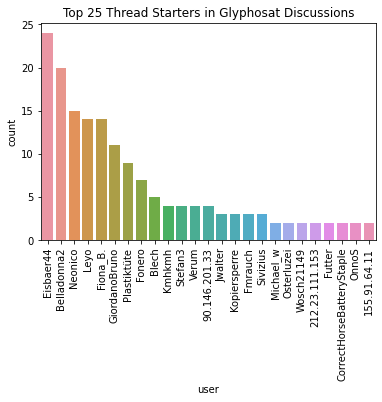

In [17]:
df = DataFrame(us.get_thread_start_count(), columns=['user', 'count'])
snb.barplot(x=df['user'], y=df['count']).set_title('Top {} Thread Starters in {} Discussions'.format(TOPK, TOPIC))
plt.xticks(rotation=90)
plt.show()

### Show Users Reacting First to a Newly Started Thread

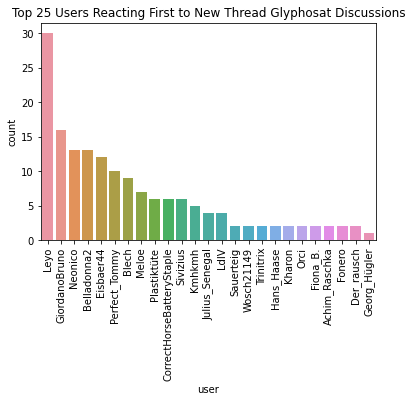

In [18]:
df = DataFrame(us.get_first_comment_count(), columns=['user', 'count'])
snb.barplot(x=df['user'], y=df['count']).set_title('Top {} Users Reacting First to New Thread {} Discussions'.format(TOPK, TOPIC))
plt.xticks(rotation=90)
plt.show()

### Show Users Reacting to, but not Starting a Thread
includes users reacting first, second, third, etc.


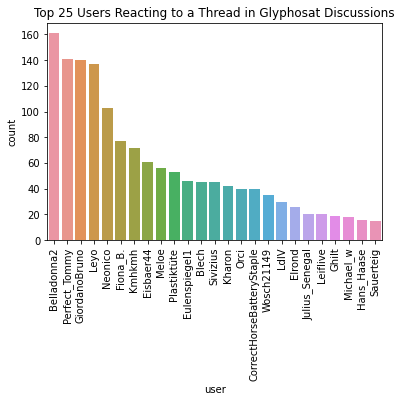

In [19]:
df = DataFrame(us.get_reaction_count(), columns=['user', 'count'])
snb.barplot(x=df['user'], y=df['count']).set_title('Top {} Users Reacting to a Thread in {} Discussions'.format(TOPK, TOPIC))
plt.xticks(rotation=90)
plt.show()